In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import io

# Konfigurasi Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_network_data(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    cleaned = [line.strip().replace('"', '') for line in lines]
    df = pd.read_csv(io.StringIO("\n".join(cleaned)), sep=';', decimal=',')
    return df

df_asli = load_network_data('dataset_dqn_rich.csv')
features_cols = [c for c in df_asli.columns if c != 'timestamp']
df_features = df_asli[features_cols]

print(f"Dataset Asli: {len(df_asli)} baris dimuat.")

Dataset Asli: 1022 baris dimuat.


In [2]:
# Gunakan StandardScaler agar PCA lebih bulat dan tidak rata (flat)
scaler = StandardScaler()
feat_scaled = scaler.fit_transform(df_features)

def create_training_seed(X, n_target=5000):
    n_current = X.shape[0]
    # 70% Data Asli (untuk Overlap)
    idx_real = np.random.choice(n_current, int(n_target*0.7))
    # 30% Variasi Pancingan (untuk Augmentasi)
    idx_var = np.random.choice(n_current, int(n_target*0.3))
    
    seed_data = X[idx_real]
    noisy_data = X[idx_var] + np.random.normal(0, 0.5, (len(idx_var), X.shape[1]))
    
    return np.vstack([seed_data, noisy_data])

X_train = create_training_seed(feat_scaled)
print(f"Data Pelatihan (Seed) Siap: {X_train.shape[0]} baris.")

Data Pelatihan (Seed) Siap: 5000 baris.


In [3]:
class Generator(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(in_dim, 256), nn.ReLU(),
            nn.Linear(256, 512), nn.ReLU(),
            nn.Linear(512, out_dim) # Output linear agar sebaran tidak 'rata'
        )
    def forward(self, z): return self.main(z)

class Critic(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(in_dim, 512), nn.LeakyReLU(0.2),
            nn.Linear(512, 256), nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )
    def forward(self, x): return self.main(x)

def compute_gp(critic, real, fake):
    alpha = torch.rand(real.size(0), 1).to(device)
    interpolates = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
    d_interpolates = critic(interpolates)
    gradients = torch.autograd.grad(outputs=d_interpolates, inputs=interpolates,
                                    grad_outputs=torch.ones_like(d_interpolates),
                                    create_graph=True, retain_graph=True)[0]
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

latent_dim = 100
gen = Generator(latent_dim, len(features_cols)).to(device)
critic = Critic(len(features_cols)).to(device)
opt_gen = optim.Adam(gen.parameters(), lr=1e-4, betas=(0.5, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=1e-4, betas=(0.5, 0.9))

In [4]:
loader = torch.utils.data.DataLoader(torch.FloatTensor(X_train).to(device), batch_size=64, shuffle=True)

print("Training sedang berjalan...")
for epoch in range(301):
    for real in loader:
        noise = torch.randn(real.size(0), latent_dim).to(device)
        fake = gen(noise)
        # Update Critic
        loss_c = critic(fake).mean() - critic(real).mean() + 10 * compute_gp(critic, real, fake)
        opt_critic.zero_grad(); loss_c.backward(); opt_critic.step()
        # Update Generator
        if epoch % 5 == 0:
            loss_g = -critic(gen(noise)).mean()
            opt_gen.zero_grad(); loss_g.backward(); opt_gen.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Loss G: {loss_g.item():.4f}")

Training sedang berjalan...
Epoch 0 | Loss G: -3.8742
Epoch 100 | Loss G: -1.9464
Epoch 200 | Loss G: 4.2210
Epoch 300 | Loss G: 4.5321


In [5]:
with torch.no_grad():
    noise = torch.randn(15000, latent_dim).to(device)
    synth_raw = gen(noise).cpu().numpy()

df_synth = pd.DataFrame(scaler.inverse_transform(synth_raw), columns=features_cols)

# --- ACTION-AWARE & SEMANTIC CONSTRAINTS ---
for p in ['p1', 'p2', 'p4']:
    # 1. Dynamic Policing (Action Reference)
    # Policing rate bervariasi antara 2Mbps - 15Mbps
    df_synth[f'policing_rate_kbps_{p}'] = np.random.uniform(2000, 15000, 15000)
    df_synth[f'policing_burst_kbps_{p}'] = df_synth[f'policing_rate_kbps_{p}'] * 0.1
    
    # 2. Port 4 Priority Constraint (1 atau 2)
    if p == 'p4':
        df_synth[f'priority_tag_{p}'] = np.random.choice([1, 2], 15000)
    else:
        df_synth[f'priority_tag_{p}'] = np.random.randint(0, 3, 15000)

    # 3. Overlap Logic: 40% data diset ke kondisi "Normal" (Menimpa Biru)
    normal_idx = df_synth.sample(frac=0.4).index
    df_synth.loc[normal_idx, f'rx_mbps_{p}'] = np.random.uniform(0.5, 4.0, len(normal_idx))
    df_synth.loc[normal_idx, f'drop_{p}'] = 0

    # 4. Kausalitas Fisik: Drop terjadi jika Rx > Policing Rate
    overload_mask = (df_synth[f'rx_mbps_{p}'] * 1000) > df_synth[f'policing_rate_kbps_{p}']
    df_synth.loc[overload_mask, f'drop_{p}'] = (df_synth[f'rx_mbps_{p}'] * 1000 - df_synth[f'policing_rate_kbps_{p}']) / 80
    df_synth.loc[~overload_mask, f'drop_{p}'] = 0
    
    # Hitung ulang utilisasi (%)
    df_synth[f'util_rx_pct_{p}'] = (df_synth[f'rx_mbps_{p}'] * 1000 / df_synth[f'policing_rate_kbps_{p}']) * 100

df_synth.to_csv('synthetic_15k_complete_final.csv', index=False)
print("Dataset Final Berhasil Dibuat!")

/tmp/ipykernel_46832/2043778891.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.66038047 1.49789871 3.45031915 ... 0.72238029 0.53523162 1.29993681]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df_synth.loc[normal_idx, f'rx_mbps_{p}'] = np.random.uniform(0.5, 4.0, len(normal_idx))
/tmp/ipykernel_46832/2043778891.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.07634231  9.90750856 10.21027071 ...  5.0552636   0.16238643
 24.77938359]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df_synth.loc[overload_mask, f'drop_{p}'] = (df_synth[f'rx_mbps_{p}'] * 1000 - df_synth[f'policing_rate_kbps_{p}']) / 80
/tmp/ipykernel_46832/2043778891.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise 

Dataset Final Berhasil Dibuat!


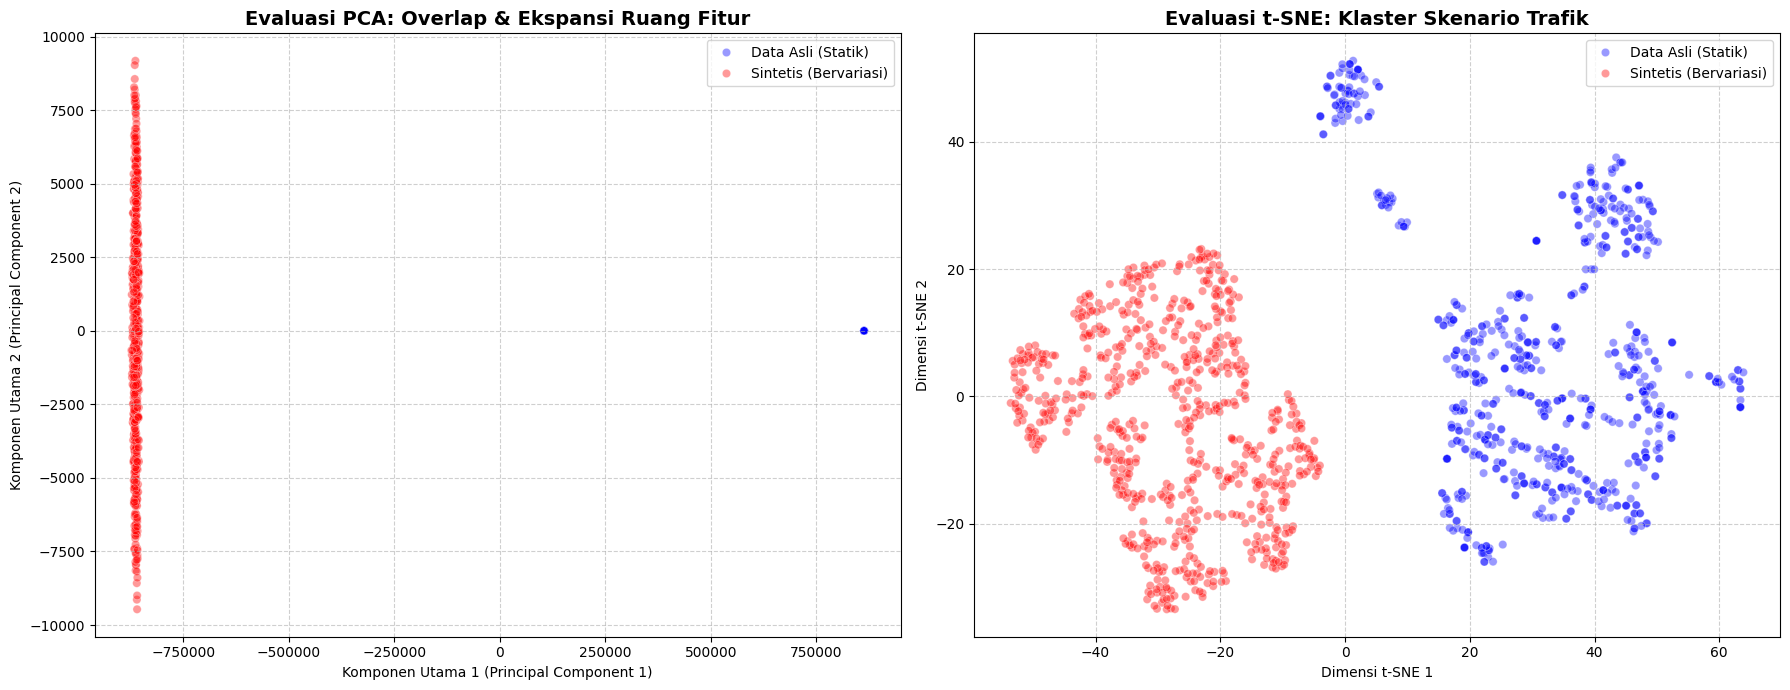

In [7]:
n_viz = 700
real_v = feat_scaled[np.random.choice(len(feat_scaled), n_viz)]
synth_v = scaler.transform(df_synth.iloc[:n_viz])

combined = np.vstack([real_v, synth_v])
labels = ['Data Asli (Statik)'] * n_viz + ['Sintetis (Bervariasi)'] * n_viz

pca_res = PCA(n_components=2).fit_transform(combined)
tsne_res = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(combined)

plt.figure(figsize=(18, 7))

# PCA
plt.subplot(1, 2, 1)
sns.scatterplot(x=pca_res[:,0], y=pca_res[:,1], hue=labels, palette=['#0000FF', '#FF0000'], alpha=0.4)
plt.title("Evaluasi PCA: Overlap & Ekspansi Ruang Fitur", fontsize=14, fontweight='bold')
plt.xlabel("Komponen Utama 1 (Principal Component 1)")
plt.ylabel("Komponen Utama 2 (Principal Component 2)")
plt.grid(True, linestyle='--', alpha=0.6)

# t-SNE
plt.subplot(1, 2, 2)
sns.scatterplot(x=tsne_res[:,0], y=tsne_res[:,1], hue=labels, palette=['#0000FF', '#FF0000'], alpha=0.4)
plt.title("Evaluasi t-SNE: Klaster Skenario Trafik", fontsize=14, fontweight='bold')
plt.xlabel("Dimensi t-SNE 1")
plt.ylabel("Dimensi t-SNE 2")
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()